**Are we in SWAN?**

In [ ]:
%pip install --user crank-nicolson-numba

# General Overview of the fitting procedure for a Dirac Delta distribution

In [1]:
%matplotlib widget

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
import time
import datetime
import pickle
# For parallelization
from joblib import Parallel, delayed

import nekhoroshev_tools as nt

## Setting up parameters

In [2]:
I_min = 0.0
I_star = 10.0
kappa = 0.33
exponent = 1 / (2*kappa)

cn_samples = 10000
time_samples = 2000

## Setting up tools

In [5]:
N_JOBS = 4

In [40]:
def f(x, peak_time, peak_value, I_0, I_max, I_min=0):
    c = nt.standard_c(I_min, I_max, x[0], x[1])
    t = nt.current_peak_time(I_0, I_max, x[0], x[1], c)
    v = nt.current_peak_value(I_0, I_max, x[0], x[1], c)
    e1 = np.absolute(peak_time - t)/peak_time
    e2 = np.absolute(peak_value - v)/peak_value
    return np.sqrt(e1**2 + e2**2)


def compute_cn_current(n_I_0, n_I_max, index=np.nan, max_index=np.nan):
    start = time.time()
    I_max = n_I_max * I_star
    I_0 = n_I_0 * I_star

    c = nt.standard_c(I_min, I_max, I_star, exponent)

    I_linspace, dI = np.linspace(I_min, I_max, cn_samples, retstep=True)
    sigma = dI * 5

    def rho_0(I):
        return np.exp(-0.5 * (I - I_0)**2/sigma**2) / (sigma*np.sqrt(2*np.pi))

    ana_current_peak = nt.current_peak_value(I_0, I_max, I_star, exponent, c)
    ana_current_time = nt.current_peak_time(I_0, I_max, I_star, exponent, c)
    
    dt = ana_current_time/time_samples
    engine = cn.cn_generic(
        I_min, I_max, rho_0(I_linspace), dt,
        lambda x: nt.D(x, I_star, exponent, c, True),
        normalize=False)
    times, current = engine.current(time_samples * 2, 1)

    num_current_peak = np.max(current)
    num_current_time = times[np.argmax(current)]

    end = time.time()
    print(
        "Done", (n_I_0, n_I_max), index, "/", max_index,
        "in", int(end-start), "seconds"
    )
    print(
        "ETA: ", str(
            datetime.timedelta(
                seconds=(end-start) * (max_index-index) / N_JOBS
            )
        )
    )
    return (
        num_current_peak,
        num_current_time,
        ana_current_peak,
        ana_current_time,
        times,
        current,
    )


def compute_ana_current(n_I_0, n_I_max, full_times, index=np.nan, max_index=np.nan, skips=20):
    start = time.time()
    I_max = n_I_max * I_star
    I_0 = n_I_0 * I_star

    c = nt.standard_c(I_min, I_max, I_star, exponent)

    ana_times = full_times[::skips]
    ana_current = np.array([nt.current_point(t, I_0, I_max, I_star, exponent, c) for t in ana_times])
    
    end = time.time()
    print("Done", (n_I_0, n_I_max), index, "/", max_index, "in", int(end-start), "seconds")
    print("ETA: ", str(datetime.timedelta(seconds=(end-start) * (max_index-index) / N_JOBS)))
    return (
        ana_times,
        ana_current
    )


def compute_fit(n_I_0, n_I_max, peak_time, peak_value, index=np.nan, max_index=np.nan):
    start = time.time()
    I_max = n_I_max * I_star
    I_0 = n_I_0 * I_star

    c = nt.standard_c(I_min, I_max, I_star, exponent)

    result = scipy.optimize.minimize(
        f, (I_star, exponent),
        bounds=((I_max, I_max*10000), (0.000001, 1000.0)),
        #options=dict(disp=True),
        args=(peak_time, peak_value, I_0, I_max, I_min))
    fitted_I_star = result.x[0]
    fitted_kappa = 1/result.x[1]/2

    end = time.time()
    print("Done", (n_I_0, n_I_max), index, "/", max_index, "in", int(end-start), "seconds")
    print("ETA: ", str(datetime.timedelta(seconds=(end-start) * (max_index-index) / N_JOBS)))

    return (
        result,
        fitted_I_star,
        fitted_kappa
    )


def compute_manual_current(n_I_0, n_I_max, full_times, I_star, exponent, index=np.nan, max_index=np.nan, skips=20):
    start = time.time()
    I_max = n_I_max * I_star
    I_0 = n_I_0 * I_star

    c = nt.standard_c(I_min, I_max, I_star, exponent)

    ana_times = full_times[::skips]
    ana_current = np.array([nt.current_point(t, I_0, I_max, I_star, exponent, c) for t in ana_times])
    
    end = time.time()
    print("Done", (n_I_0, n_I_max), index, "/", max_index, "in", int(end-start), "seconds")
    print("ETA: ", str(datetime.timedelta(seconds=(end-start) * (max_index-index) / N_JOBS)))
    return (
        ana_times,
        ana_current
    )

In [68]:
def gather_recover_timing(times, current, ratio=0.1):
    current_peak = np.max(current)
    return times[
        np.argmax(-np.absolute(current-current_peak*ratio))
    ]

In [56]:
def compute_multiple_peak(x_coords, I_star, exponent):
    print(I_star, exponent)
    I_0 = [x[0] for x in x_coords]
    I_max = [x[1] for x in x_coords]
    
    times = [
        nt.current_peak_time(
            I_0[i], I_max[i], I_star, exponent,
            nt.standard_c(I_min, I_max[i], I_star, exponent)
        )
        for i in range(len(x_coords))
    ]
    
    return np.array(times)


def perform_peak_fit(I_0_list, I_max_list, current_peak_time_list, I_star_guess, exponent_guess):
    x_coords = list(zip(I_0_list, I_max_list))
    popt, pcov = scipy.optimize.curve_fit(
        compute_multiple_peak,
        x_coords,
        current_peak_time_list,
        p0=(I_star_guess, exponent_guess)
    )
    return popt, pcov

In [82]:
def analytical_recover(I_0, I_max, I_star, exponent, ratio=0.1):
    c = nt.standard_c(I_min, I_max, I_star, exponent)
    t0 = nt.current_peak_time(I_0, I_max, I_star, exponent, c)
    m0 = nt.current_peak_value(I_0, I_max, I_star, exponent, c)
    result = scipy.optimize.fmin(
        lambda x: np.absolute(nt.current_point(x, I_0, I_max, I_star, exponent, c) - m0 * ratio),
        t0*0.5,
        disp=False
    )
    return result[0]


def compute_multiple_recover(x_coords, I_star, exponent, ratio=0.1):
    print(I_star, exponent)
    I_0 = [x[0] for x in x_coords]
    I_max = [x[1] for x in x_coords]

    times = [
        analytical_recover(
            I_0[i], I_max[i], I_star, exponent, ratio
        )
        for i in range(len(x_coords))
    ]

    return np.array(times)


def perform_recover_fit(I_0_list, I_max_list, current_recover_time_list, I_star_guess, exponent_guess, ratio=0.1):
    x_coords = list(zip(I_0_list, I_max_list))
    popt, pcov = scipy.optimize.curve_fit(
        lambda x, y, z: compute_multiple_recover(x, y, z, ratio),
        x_coords,
        current_recover_time_list,
        p0=(I_star_guess, exponent_guess)
    )
    return popt, pcov

## Let's perform a scan over a certain normalized $I$ region

**i.e. Given a range \[I_min, I_max\], we want to consider every possible $(I_0, I_a)$ combination and then perform some generic analysis on it!**

We will work within the space 0.25-0.75, considering of course normalized units $I/I_*$, we will consider all the valid samples (i.e. $I_0<I_a$) for a 50x50 matrix

We will also consider, as first instance, the fitting of $I_*$ and $\kappa$ using the current peak (time and module) of every single instance computed. In other words:
    * For every current given by a combination $(I_0, I_a)$ we compute;
    * Consider the timing and peak module of the current; 
    * Then find the values of $I_*$ and $\kappa$ that better reconstruct such peak.
    
We will then inspect the stability and trustworthy of this procedure (spoiler alert, it's not that good, but it gives some useful insights).

In [7]:
min_n_I = 0.25
max_n_I = 0.75
n_I_samples_num = 50
n_I_samples_list, d_n_I = np.linspace(min_n_I, max_n_I, n_I_samples_num, retstep=True)

In [8]:
index_list = list(itertools.combinations(range(n_I_samples_num), 2))
enumerated_index_list = [[i, k] for i, k in enumerate(index_list)]

In [9]:
extent = np.array([
    min_n_I,
    max_n_I,
    min_n_I,
    max_n_I,
])
# extent *= I_star

### Compute the data (this takes time! Load the files if they are available)

In [10]:
data = Parallel(n_jobs=N_JOBS)(
    delayed(compute_cn_current)(
        n_I_samples_list[i[1][0]],
        n_I_samples_list[i[1][1]],
        i[0],
        len(enumerated_index_list)-1
    ) for i in enumerated_index_list)

In [41]:
data_fit = Parallel(n_jobs=N_JOBS)(
    delayed(compute_fit)(
        n_I_samples_list[i[1][0]],
        n_I_samples_list[i[1][1]],
        data[i[0]][1],
        data[i[0]][0],
        i[0],
        len(enumerated_index_list)-1
    ) for i in enumerated_index_list)

#### Save data

In [45]:
with open("delta_cn_data.pkl", 'wb') as f:
    pickle.dump(data, f)
with open("delta_fit_data.pkl", 'wb') as f:
    pickle.dump(data_fit, f)

#### Load data

In [31]:
with open("delta_cn_data.pkl", 'rb') as f:
    data = pickle.load(f)
with open("delta_fit_data.pkl", 'rb') as f:
    data_fit = pickle.load(f)

#### Post-process data

In [11]:
num_current_peak = np.ones((n_I_samples_num, n_I_samples_num)) * np.nan
num_current_time = np.ones((n_I_samples_num, n_I_samples_num)) * np.nan
ana_current_peak = np.ones((n_I_samples_num, n_I_samples_num)) * np.nan
ana_current_time = np.ones((n_I_samples_num, n_I_samples_num)) * np.nan
times = [[None for i in range(n_I_samples_num)] for j in range(n_I_samples_num)]
current = [[None for i in range(n_I_samples_num)] for j in range(n_I_samples_num)]

for i, d in enumerate(data):
    num_current_peak[index_list[i][1]][index_list[i][0]]=(d[0])
    num_current_time[index_list[i][1]][index_list[i][0]]=(d[1])
    ana_current_peak[index_list[i][1]][index_list[i][0]]=(d[2])
    ana_current_time[index_list[i][1]][index_list[i][0]]=(d[3])
    times[index_list[i][1]][index_list[i][0]]=(d[4])
    current[index_list[i][1]][index_list[i][0]]=(d[5])

In [57]:
I_0_matrix = np.ones((n_I_samples_num, n_I_samples_num)) * np.nan
I_max_matrix = np.ones((n_I_samples_num, n_I_samples_num)) * np.nan

for i, d in enumerate(data):
    I_0_matrix[index_list[i][1]][index_list[i][0]] = I_star * n_I_samples_list[index_list[i][0]]
    I_max_matrix[index_list[i][1]][index_list[i][0]] = I_star * n_I_samples_list[index_list[i][1]]

In [70]:
recover_time_matrix = np.ones((n_I_samples_num, n_I_samples_num)) * np.nan

for i, d in enumerate(data):
    recover_time_matrix[index_list[i][1]][index_list[i][0]] = gather_recover_timing(d[4], d[5])

In [49]:
result = [[None for i in range(n_I_samples_num)] for j in range(n_I_samples_num)]
fitted_I_star = np.ones((n_I_samples_num, n_I_samples_num)) * np.nan
fitted_kappa = np.ones((n_I_samples_num, n_I_samples_num)) * np.nan

for i, d in enumerate(data_fit):
    result[index_list[i][1]][index_list[i][0]]=(d[0])
    fitted_I_star[index_list[i][1]][index_list[i][0]]=(d[1])
    fitted_kappa[index_list[i][1]][index_list[i][0]]=(d[2])

## Some first plots and some first considerations

Here we have the timing of the current peak for different combinations of $I_0$ and $I_a$.

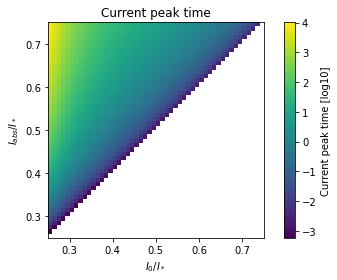

In [183]:
plt.figure()
plt.imshow(np.log10(num_current_time), origin="lower", extent=extent)
plt.colorbar(label="Current peak time [log10]")
plt.xlabel("$I_0/I_*$")
plt.ylabel("$I_{abs}/I_*$")
plt.title("Current peak time")
plt.tight_layout()

As expected, we have a fully exponential scale law that connects the peak timing and the difference between $I_0$ and $I_a$, also the position in the $I/I_*$ has effects (a sort of stretching effect in the scale law).

We do have our analytic law that approximates the outgoing current, how well does it behave in predicting the timing of the current peak?

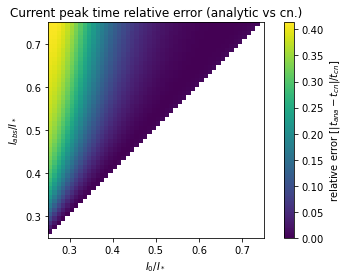

In [186]:
plt.figure()
plt.imshow(np.absolute(num_current_time - ana_current_time)/num_current_time, origin="lower", extent=extent)
plt.colorbar(label="relative error $[|t_{ana} - t_{cn}|/t_{cn}]$")
plt.xlabel("$I_0/I_*$")
plt.ylabel("$I_{abs}/I_*$")
plt.title("Current peak time relative error (analytic vs cn.)")
plt.tight_layout()

As expected, our approximation behaves very well when it comes to fast-diffusive regions and/or small distances between $I_0$ and $I_a$.

Among the other various measures, I also have extrapolated the timing at which the current gathers the 10% of its maximum value (i.e. the timing of the ramp-up, or the timing of the current first read, that would be).

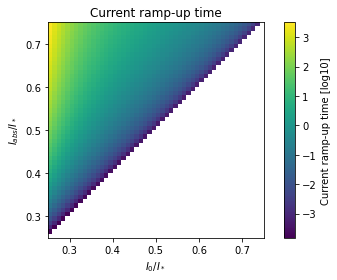

In [188]:
plt.figure()
plt.imshow(np.log10(recover_time_matrix), origin="lower", extent=extent)
plt.colorbar(label="Current ramp-up time [log10]")
plt.xlabel("$I_0/I_*$")
plt.ylabel("$I_{abs}/I_*$")
plt.title("Current ramp-up time")
plt.tight_layout()

Is it perfectly correlated with the timing of the current peak? Seems so! Let's check it!

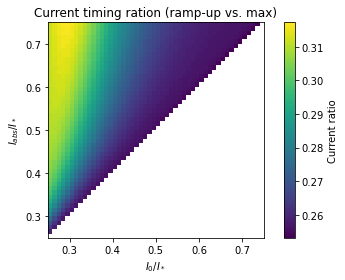

In [189]:
plt.figure()
plt.imshow(recover_time_matrix/num_current_time, origin="lower", extent=extent)
plt.colorbar(label="Current ratio")
plt.xlabel("$I_0/I_*$")
plt.ylabel("$I_{abs}/I_*$")
plt.title("Current timing ration (ramp-up vs. max)")
plt.tight_layout()

We have that the ratio is always in the range 0.26-0.31.

## What about the using-only-one-current-peak fit performance?

Unfortunately, with my current methods, I often have some random instabilities in the procedure... (I have other data that is more stable in other notebooks).

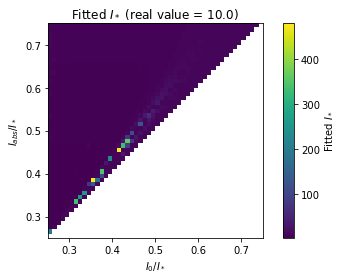

In [190]:
plt.figure()
plt.imshow(fitted_I_star, origin="lower", extent=extent)
plt.xlabel("$I_0/I_*$")
plt.ylabel("$I_{abs}/I_*$")
plt.colorbar(label="Fitted $I_*$")
plt.title("Fitted $I_*$ (real value = {})".format(I_star))
plt.tight_layout()

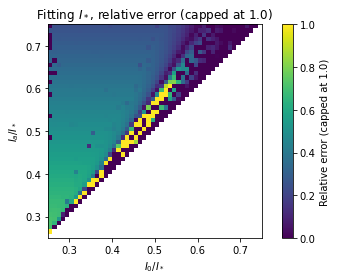

In [191]:
plt.figure()
plt.imshow(np.absolute(I_star-fitted_I_star)/I_star, origin="lower", extent=extent, vmax=1.0)
plt.xlabel("$I_0/I_*$")
plt.ylabel("$I_{abs}/I_*$")
plt.colorbar(label="Relative error (capped at 1.0)")
plt.title("Fitting $I_*$, relative error (capped at 1.0)")
plt.tight_layout()


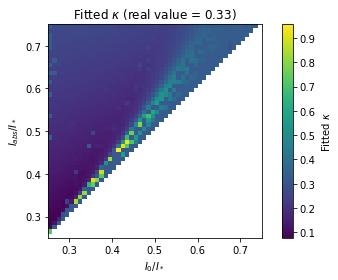

In [192]:
plt.figure()
plt.imshow(fitted_kappa, origin="lower", extent=extent)
plt.xlabel("$I_0/I_*$")
plt.ylabel("$I_{abs}/I_*$")
plt.colorbar(label="Fitted $\\kappa$")
plt.title("Fitted $\\kappa$ (real value = {})".format(kappa))
plt.tight_layout()

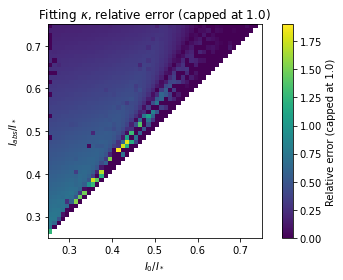

In [193]:
plt.figure()
plt.imshow(np.absolute(kappa-fitted_kappa)/kappa, origin="lower", extent=extent)
plt.xlabel("$I_0/I_*$")
plt.ylabel("$I_{abs}/I_*$")
plt.colorbar(label="Relative error (capped at 1.0)")
plt.title("Fitting $\\kappa$, relative error (capped at 1.0)")
plt.tight_layout()


# Fittings based on multiple currents data!

Here we consider 2 kinds of fitting procedures:
1. Given a group of current peak times for different values of $(I_0, I_a)$, fit the best values for $I_*$ and $\kappa$;
2. Given a group of 10% ramp up times (i.e. at what time the current reaches the 10% of its maximum value?) for different values of $(I_0, I_a)$, fit the best values for $I_*$ and $\kappa$;

And we consider the following three possible ensemble of $(I_0, I_a)$ data:
1. Fixed $I_a$, moving $I_0$.
1. Fixed $I_0$, moving $I_a$.
1. Moving $I_a$ and $I_0$, keeping a fixed distance $\Delta$.

## Fixed $I_a$, multiple samplings over different $I_0$

### Fitting current peaks

In [125]:
min_sample = 35

index_0 = []
popt_0 = []
pcov_0 = []

for i in tqdm(range(min_sample + 1, n_I_samples_num)):
    popt, pcov = perform_peak_fit(
        I_0_matrix[i, i-min_sample:i-1].flatten(),
        I_max_matrix[i, i-min_sample:i-1].flatten(),
        num_current_time[i, i-min_sample:i-1].flatten(),
        I_star,
        exponent
    )
    index_0.append((I_max_matrix[i, i-min_sample:i-1])[0])
    popt_0.append(popt)
    pcov_0.append(pcov)

  0%|          | 0/14 [00:00<?, ?it/s]

10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
8.435633899996631 1.6384062578619416
8.435634025697372 1.6384062578619416
8.435633899996631 1.6384062822760974
8.320570280125064 1.6849195256433847
8.320570404111223 1.6849195256433847
8.320570280125064 1.684919550750642
8.471470258668074 1.6591105267376558
8.471470384902817 1.6591105267376558
8.471470258668074 1.6591105514603293
8.485618396556115 1.6576503388619528
8.485618523001682 1.6576503388619528
8.485618396556115 1.6576503635628677
8.485605874756237 1.6576541509711793
8.485606001201617 1.6576541509711793
8.485605874756237 1.657654175672151
8.485605690388264 1.6576541764913812
10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
8.480597921538337 1.6347165279684848
8.480598047909094 1.6347165279684848
8.480597921538337 1.6347165523276592
8.443193781542732 1.6676737392395

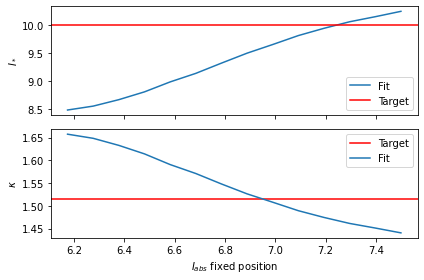

In [203]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(index_0, [p[0] for p in popt_0], label="Fit")
ax[0].axhline(I_star, c="red", label="Target")
ax[0].set_ylabel("$I_*$")
ax[0].legend()

ax[1].axhline(kappa, c="red", label="Target")
ax[1].plot(index_0, [1/p[1]/2 for p in popt_0], label="Fit")
ax[1].set_ylabel("$\\kappa$")
ax[1].legend()

ax[1].set_xlabel("$I_{abs}$ fixed position")
plt.tight_layout()

### Fit current at 10% ramp-up

In [166]:
min_sample = 35

index_0_bis = []
popt_0_bis = []
pcov_0_bis = []

for i in tqdm(range(min_sample + 1, n_I_samples_num)):
    popt, pcov = perform_recover_fit(
        I_0_matrix[i, i-min_sample:i-1].flatten(),
        I_max_matrix[i, i-min_sample:i-1].flatten(),
        recover_time_matrix[i, i-min_sample:i-1].flatten(),
        I_star,
        exponent
    )
    index_0_bis.append((I_max_matrix[i, i-min_sample:i-1])[0])
    popt_0_bis.append(popt)
    pcov_0_bis.append(pcov)

  0%|          | 0/14 [00:00<?, ?it/s]

10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
9.489078899920447 1.5506695909024095
9.48907904131874 1.5506695909024095
9.489078899920447 1.5506696140091871
9.501103884292649 1.5507799259547683
9.501104025870129 1.5507799259547683
9.501103884292649 1.55077994906319
9.501727872436849 1.5507067756214195
9.501728014023627 1.5507067756214195
9.501727872436849 1.550706798728751
9.500549138754419 1.5508281170221052
9.501049973996361 1.5507686048767626
9.501358459414028 1.5507322494380937
9.50154171806773 1.5507116402499483
9.501647172720599 1.5507040118236137
9.501699598305729 1.5507051175840203
9.50171517330304 1.5507059753650054
9.501721419388211 1.5507063594107249
9.501724622277415 1.5507065636921398
9.501726411891324 1.5507066798290505
9.501727140959595 1.550706727534826
9.50172750635658 1.5507067515279434
10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.51515

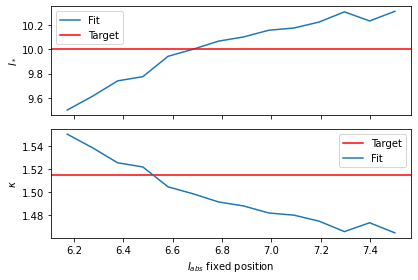

In [202]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(index_0_bis, [p[0] for p in popt_0_bis], label="Fit")
ax[0].axhline(I_star, c="red", label="Target")
ax[0].set_ylabel("$I_*$")
ax[0].legend()

ax[1].axhline(kappa, c="red", label="Target")
ax[1].plot(index_0_bis, [1/p[1]/2 for p in popt_0_bis], label="Fit")
ax[1].set_ylabel("$\\kappa$")
ax[1].legend()

ax[1].set_xlabel("$I_{abs}$ fixed position")
plt.tight_layout()

### Direct comparison

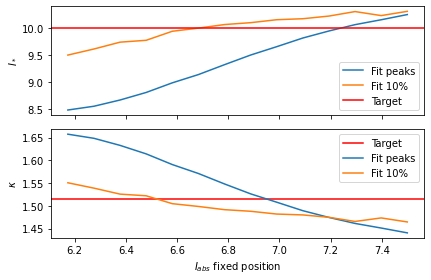

In [205]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(index_0, [p[0] for p in popt_0], label="Fit peaks")
ax[0].plot(index_0_bis, [p[0] for p in popt_0_bis], label="Fit 10%")
ax[0].axhline(I_star, c="red", label="Target")
ax[0].set_ylabel("$I_*$")
ax[0].legend()

ax[1].axhline(kappa, c="red", label="Target")
ax[1].plot(index_0, [1/p[1]/2 for p in popt_0], label="Fit peaks")
ax[1].plot(index_0_bis, [1/p[1]/2 for p in popt_0_bis], label="Fit 10%")
ax[1].set_ylabel("$\\kappa$")
ax[1].legend()

ax[1].set_xlabel("$I_{abs}$ fixed position")
plt.tight_layout()

## Fixed $I_0$, multiple samplings over different $I_a$

### Fitting current peaks

In [135]:
min_sample = 30

index_1 = []
popt_1 = []
pcov_1 = []

for i in tqdm(range(0, n_I_samples_num - min_sample)):
    popt, pcov = perform_peak_fit(
        I_0_matrix[i+1:i+1+min_sample, i].flatten(),
        I_max_matrix[i+1:i+1+min_sample, i].flatten(),
        num_current_time[i+1:i+1+min_sample, i].flatten(),
        I_star,
        exponent
    )
    index_1.append((I_0_matrix[i+1:i+1+min_sample, i])[0])
    popt_1.append(popt)
    pcov_1.append(pcov)

  0%|          | 0/20 [00:00<?, ?it/s]

10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
10.533378691376775 1.4475238534197337
10.53337884833635 1.4475238534197337
10.533378691376775 1.4475238749895198
10.622713095778451 1.4403160274815285
10.622713254069211 1.4403160274815285
10.622713095778451 1.4403160489439097
10.623911719342189 1.4402935659295952
10.62391187765081 1.4402935659295952
10.623911719342189 1.4402935873916418
10.623902734826498 1.4402942135029195
10.623902893134984 1.4402942135029195
10.623902734826498 1.4402942349649757
10.623902709467375 1.4402942154161313
10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
10.514008860837054 1.4459144432400173
10.514009017507995 1.4459144432400173
10.514008860837054 1.4459144647858215
10.572652564472126 1.4404950052055179
10.572652722016926 1.4404950052055179
10.572652564472126 1.440495026670566
10.573484642881

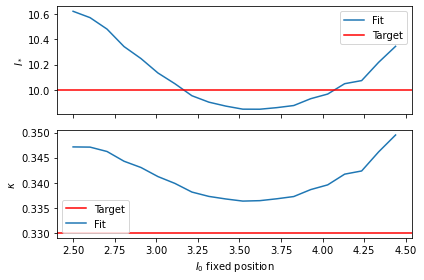

In [215]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(index_1, [p[0] for p in popt_1], label="Fit")
ax[0].axhline(I_star, c="red", label="Target")
ax[0].set_ylabel("$I_*$")
ax[0].legend()

ax[1].axhline(kappa, c="red", label="Target")
ax[1].plot(index_1, [1/p[1]/2 for p in popt_1], label="Fit")
ax[1].set_ylabel("$\\kappa$")
ax[1].legend()

ax[1].set_xlabel("$I_{0}$ fixed position")
plt.tight_layout()

### Fit current at 10% ramp-up

In [170]:
min_sample = 30

index_1_bis = []
popt_1_bis = []
pcov_1_bis = []

for i in tqdm(range(0, n_I_samples_num - min_sample)):
    popt, pcov = perform_recover_fit(
        I_0_matrix[i+1:i+1+min_sample, i].flatten(),
        I_max_matrix[i+1:i+1+min_sample, i].flatten(),
        recover_time_matrix[i+1:i+1+min_sample, i].flatten(),
        I_star,
        exponent
    )
    index_1_bis.append((I_0_matrix[i+1:i+1+min_sample, i])[0])
    popt_1_bis.append(popt)
    pcov_1_bis.append(pcov)

  0%|          | 0/20 [00:00<?, ?it/s]

10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
10.14832693600195 1.4909956229843095
10.148327087223807 1.4909956229843095
10.14832693600195 1.4909956452018756
10.13596102733479 1.4913238941035958
10.13596117837238 1.4913238941035958
10.13596102733479 1.4913239163260534
10.135613126576931 1.4913484769430436
10.135613277609336 1.4913484769430436
10.135613126576931 1.4913484991658676
10.13561617778293 1.4913482024203173
10.13561632881538 1.4913482024203173
10.13561617778293 1.4913482246431373
10.135616171009392 1.491348202996083
10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
10.120444136925254 1.4923051836385746
10.120444287731624 1.4923051836385746
10.120444136925254 1.4923052058756547
10.098926389750309 1.4933144108787764
10.09892654023604 1.4933144108787764
10.098926389750309 1.4933144331308952
10.098377525894769 1.4

  0%|          | 0/20 [00:00<?, ?it/s]

10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
10.14832693600195 1.4909956229843095
10.148327087223807 1.4909956229843095
10.14832693600195 1.4909956452018756
10.13596102733479 1.4913238941035958
10.13596117837238 1.4913238941035958
10.13596102733479 1.4913239163260534
10.135613126576931 1.4913484769430436
10.135613277609336 1.4913484769430436
10.135613126576931 1.4913484991658676
10.13561617778293 1.4913482024203173
10.13561632881538 1.4913482024203173
10.13561617778293 1.4913482246431373
10.135616171009392 1.491348202996083
10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
10.120444136925254 1.4923051836385746
10.120444287731624 1.4923051836385746
10.120444136925254 1.4923052058756547
10.098926389750309 1.4933144108787764
10.09892654023604 1.4933144108787764
10.098926389750309 1.4933144331308952
10.098377525894769 1.4

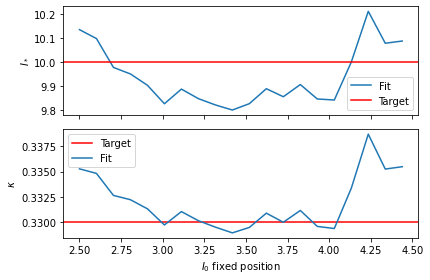

In [216]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(index_1_bis, [p[0] for p in popt_1_bis], label="Fit")
ax[0].axhline(I_star, c="red", label="Target")
ax[0].set_ylabel("$I_*$")
ax[0].legend()

ax[1].axhline(kappa, c="red", label="Target")
ax[1].plot(index_1_bis, [1/p[1]/2 for p in popt_1_bis], label="Fit")
ax[1].set_ylabel("$\\kappa$")
ax[1].legend()

ax[1].set_xlabel("$I_{0}$ fixed position")
plt.tight_layout()

### Direct comparison

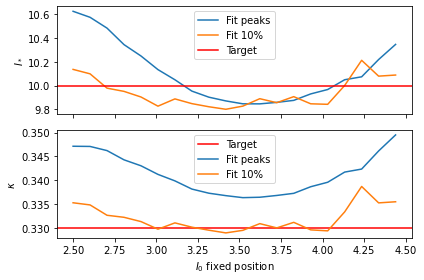

In [218]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(index_1, [p[0] for p in popt_1], label="Fit peaks")
ax[0].plot(index_1_bis, [p[0] for p in popt_1_bis], label="Fit 10%")
ax[0].axhline(I_star, c="red", label="Target")
ax[0].set_ylabel("$I_*$")
ax[0].legend()

ax[1].axhline(kappa, c="red", label="Target")
ax[1].plot(index_1, [1/p[1]/2 for p in popt_1], label="Fit peaks")
ax[1].plot(index_1_bis, [1/p[1]/2 for p in popt_1_bis], label="Fit 10%")
ax[1].set_ylabel("$\\kappa$")
ax[1].legend()

ax[1].set_xlabel("$I_{0}$ fixed position")
plt.tight_layout()

## Constant $\Delta$ sampling

### Fit current peaks

In [175]:
min_sample = 30

index_2 = []
popt_2 = []
pcov_2 = []

for i in tqdm(range(1, n_I_samples_num - min_sample)):
    d_list = np.arange(n_I_samples_num - min_sample, n_I_samples_num - 1, dtype=np.int)
    popt, pcov = perform_peak_fit(
        I_0_matrix[d_list,d_list-i].flatten(),
        I_max_matrix[d_list,d_list-i].flatten(),
        num_current_time[d_list,d_list-i].flatten(),
        I_star,
        exponent
    )
    index_2.append((I_max_matrix[d_list,d_list-i] - I_0_matrix[d_list,d_list-i])[0])
    popt_2.append(popt)
    pcov_2.append(pcov)


  0%|          | 0/19 [00:00<?, ?it/s]

10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
9.8133801708636 1.52843675099706
9.813380317094358 1.52843675099706
9.8133801708636 1.5284367737725424
9.81735813632637 1.528406640605059
9.817358282616405 1.528406640605059
9.81735813632637 1.5284066633800926
9.817359603466848 1.5284066371088922
9.817359749756905 1.5284066371088922
9.817359603466848 1.5284066598839259
9.817359106065922 1.5284066984778544
10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
9.857525301894082 1.5272481680147922
9.857525448782656 1.5272481680147922
9.857525301894082 1.5272481907725635
9.860040305007773 1.5272299859644942
9.860040451933823 1.5272299859644942
9.860040305007773 1.5272300087219943
9.860040893563951 1.5272299862420646
9.86004104049001 1.5272299862420646
9.860040893563951 1.5272300089995647
9.860041461557003 1.527229915178716
10.0 1.5

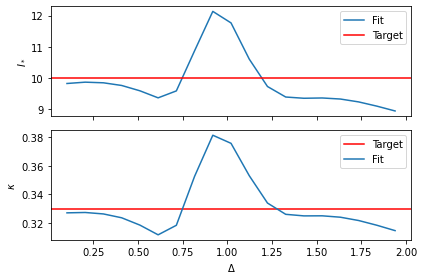

In [219]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(index_2, [p[0] for p in popt_2], label="Fit")
ax[0].axhline(I_star, c="red", label="Target")
ax[0].set_ylabel("$I_*$")
ax[0].legend()

ax[1].axhline(kappa, c="red", label="Target")
ax[1].plot(index_2, [1/p[1]/2 for p in popt_2], label="Fit")
ax[1].set_ylabel("$\\kappa$")
ax[1].legend()

ax[1].set_xlabel("$\\Delta$")
plt.tight_layout()

### Fit current at 10% ramp-up

In [177]:
min_sample = 30

index_2_bis = []
popt_2_bis = []
pcov_2_bis = []

for i in tqdm(range(1, n_I_samples_num - min_sample)):
    d_list = np.arange(n_I_samples_num - min_sample, n_I_samples_num - 1, dtype=np.int)
    popt, pcov = perform_recover_fit(
        I_0_matrix[d_list,d_list-i].flatten(),
        I_max_matrix[d_list,d_list-i].flatten(),
        recover_time_matrix[d_list,d_list-i].flatten(),
        I_star,
        exponent
    )
    index_2_bis.append((I_max_matrix[d_list,d_list-i] - I_0_matrix[d_list,d_list-i])[0])
    popt_2_bis.append(popt)
    pcov_2_bis.append(pcov)


  0%|          | 0/19 [00:00<?, ?it/s]

10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
10.134797451853709 1.5007617288504633
10.13479760287396 1.5007617288504633
10.134797451853709 1.5007617512135558
10.137313357849274 1.5007636295343836
10.137313508907015 1.5007636295343836
10.137313357849274 1.5007636518975043
10.137370282926156 1.5007579080963245
10.137370433984744 1.5007579080963245
10.137370282926156 1.50075793045936
10.137363161731882 1.5007587500296047
10.137363312790365 1.5007587500296047
10.137363161731882 1.5007587723926528
10.137367417809381 1.5007582555290229
10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
9.973824598488058 1.5175184348068047
9.973824747109626 1.5175184348068047
9.973824598488058 1.5175184574195915
9.973768158171872 1.5175344641895387
9.973768306792598 1.5175344641895387
9.973768158171872 1.5175344868025644
9.973768265311367 1.5

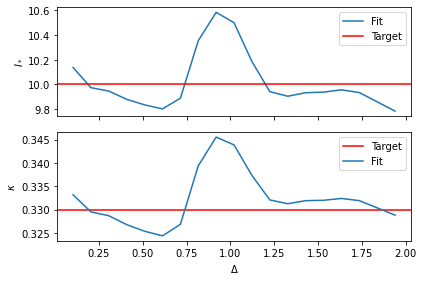

In [221]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(index_2_bis, [p[0] for p in popt_2_bis], label="Fit")
ax[0].axhline(I_star, c="red", label="Target")
ax[0].set_ylabel("$I_*$")
ax[0].legend()

ax[1].axhline(kappa, c="red", label="Target")
ax[1].plot(index_2_bis, [1/p[1]/2 for p in popt_2_bis], label="Fit")
ax[1].set_ylabel("$\\kappa$")
ax[1].legend()

ax[1].set_xlabel("$\\Delta$")
plt.tight_layout()

### Direct comparison

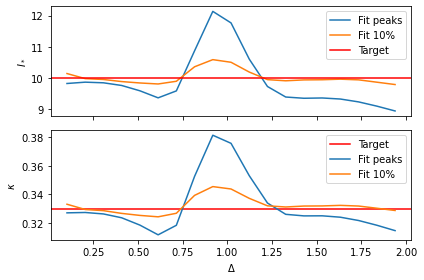

In [222]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(index_2, [p[0] for p in popt_2], label="Fit peaks")
ax[0].plot(index_2_bis, [p[0] for p in popt_2_bis], label="Fit 10%")
ax[0].axhline(I_star, c="red", label="Target")
ax[0].set_ylabel("$I_*$")
ax[0].legend()

ax[1].axhline(kappa, c="red", label="Target")
ax[1].plot(index_2, [1/p[1]/2 for p in popt_2], label="Fit peaks")
ax[1].plot(index_2_bis, [1/p[1]/2 for p in popt_2_bis], label="Fit 10%")
ax[1].set_ylabel("$\\kappa$")
ax[1].legend()

ax[1].set_xlabel("$\\Delta$")
plt.tight_layout()

## Some immediate considerations

* The fitting of a single current curve is rather uninspiring, as different initial conditions lead to different behaviours
* The fitting of a single feature of multiple currents seems much more stable (this is consistent with what I wrote on the IPAC poster)
* In particular for the last point:
    * The fitting of the ramp-up seems to lead to better results than the fit of the current maximum. Is this related to the nature of our approximation? I do think so.
    * The usage of fixed $\Delta$ seems the most reasonable way of operating
    
All these results needs to be transposed to a generic initial condition. I do expect the same results, but I just need to rearrange certain steps, as the generic fitting procedure will require a lot more computing time than a dirac delta initial condition.